### A Triangulation-Based Backward Adaptive Motion Field Subsampling Scheme

Implementation of the paper

#### https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9287064

In [1]:
import torch
import numpy as np
import os
import sys
import warnings

warnings.filterwarnings('ignore')
import imageio
from compressai.zoo import mbt2018_mean
import wandb
import argparse
import logging
import time
import random
from torch import optim

from torch.utils.data import DataLoader, RandomSampler

model_path = os.path.abspath('..')
sys.path.insert(1, model_path)

from model import p_m
from utils import float_to_uint8, MSE, PSNR, calculate_distortion_loss
from utils import TrainDataset, TestDataset
from utils import image_compress, save_model, load_optimizer
from utils import load_model, build_info, update_train_info
from utils import update_val_info, update_best_val_info, zero_train_info

torch.backends.cudnn.benchmark = True

In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
device = torch.device("cuda")

model3141 = p_m.Model().to(device).float()

checkpoint3141 = torch.load("DVC3141.pth", map_location=device)

model3141 = load_model(model3141, checkpoint3141)

#    for param in model.opticFlow.parameters():
#        param.requires_grad = False
#    for param in model.warpnet.parameters():
#        param.requires_grad = False

image_compressor = mbt2018_mean(quality=8, metric="mse", 
                                pretrained=True).to(device).float()

image_compressor = image_compressor.eval()

In [4]:
test_dataset = TestDataset(
    "/userfiles/ecetin17/full_test/", 
    gop_size=8, 
    skip_frames=4
)

In [5]:
with torch.no_grad():
    model3141.eval()

    average_loss = 0
    average_bpp = 0
    average_psnr = 0

    total_pixels = 0
    total_frames = 0

    data = test_dataset[1]
    name = data["name"]
    frames = data["frames"].to(device).float()
    
    x1 = frames[0]
    b, c, h, w = x1.shape
    
    dec1, size1 = image_compress(x1, image_compressor)
    uint8_real1 = float_to_uint8(x1[0, :, :h, :w].cpu().numpy())

    uint8_dec_out1 = float_to_uint8(dec1[0, :, :h, :w].cpu().detach().numpy())
    PSNR1 = PSNR(MSE(uint8_dec_out1.astype(np.float64), uint8_real1.astype(np.float64)), data_range=255)
    average_psnr += PSNR1
    average_bpp += size1
    
    pixels1 = uint8_real1.shape[0] * uint8_real1.shape[1]
    total_pixels += pixels1
    total_frames += 1

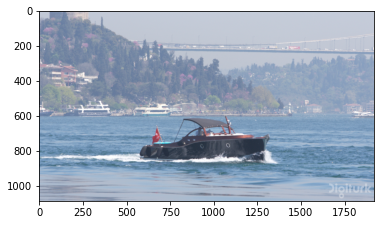

In [6]:
plt.imshow(uint8_real1)
plt.show()

In [7]:
with torch.no_grad():
    model3141.eval()
    
    x2 = frames[1]

    dec2, rate2, size2, mv_p2c = model3141(dec1, x2, False, warped=False)

    average_bpp += size2

    uint8_real2 = float_to_uint8(x2[0, :, :h, :w].cpu().numpy())
    uint8_dec_out2 = float_to_uint8(dec2[0, :, :h, :w].cpu().detach().numpy())

    PSNR2 = PSNR(MSE(uint8_dec_out2.astype(np.float64), uint8_real2.astype(np.float64)), data_range=255)
    average_psnr += PSNR2

    pixels2 = uint8_real2.shape[0] * uint8_real2.shape[1]
    total_pixels += pixels2
    # d += 1
    total_frames += 1

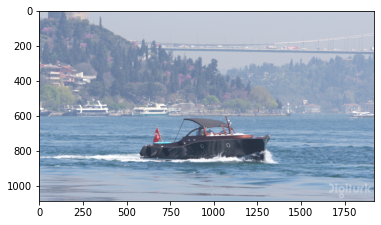

In [8]:
plt.imshow(uint8_real2)
plt.show()

In [9]:
mv = mv_p2c.squeeze()
flow = mv_p2c.permute((0, 2, 3, 1)).squeeze(0).cpu().numpy()
print(flow.shape)

(1088, 1920, 2)


In [10]:
UNKNOWN_FLOW_THRESH = 1e7
SMALLFLOW = 0.0
LARGEFLOW = 1e8


def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    print("max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

In [11]:
def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

In [12]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [13]:
flow_img = flow_to_image(flow)

max flow: 25.0781
flow range:
u = -8.977 .. 25.063
v = -11.243 .. 6.753


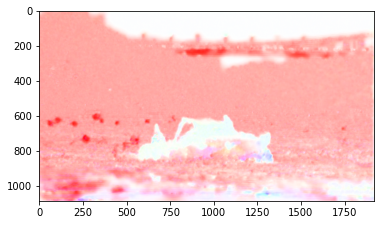

In [14]:
plt.imshow(flow_img)
plt.show()

In [15]:
size = flow_img.shape
rect = (0, 0, size[1], size[0])
subdiv  = cv2.Subdiv2D(rect)

In [16]:
corners = []

In [17]:
for i in np.linspace(0, size[1]-1, 8):
    for j in np.linspace(0, size[0]-1, 8):
        corners.append((int(i), int(j)))
        subdiv.insert((int(i), int(j)))

In [18]:
def area_from_corners(pt1, pt2, pt3):
    """
    Calculate the area of a triangle from its corner coordinates
    pt1: corner 1 as a np.array
    pt2: corner 2 as a np.array
    pt3: corner 3 as a np.array
    """
    nominator = pt1[0] * (pt2[1] - pt3[1])
    nominator += pt2[0] * (pt3[1] - pt1[1])
    nominator += pt3[0] * (pt1[1] - pt2[1])
    return abs(nominator / 2)

In [19]:
def triangle_score(flow, pt1, pt2, pt3):
    """
    Calculate the triangle score
    flow: flow data (2, H, W),
    pt1: corner 1 as a np.array
    pt2: corner 2 as a np.array
    pt3: corner 3 as a np.array
    """
    uv1 = flow[:, int(pt1[1]), int(pt1[0])]
    uv2 = flow[:, int(pt2[1]), int(pt2[0])]
    uv3 = flow[:, int(pt3[1]), int(pt3[0])]
    
    xs = torch.tensor([uv1[0], uv2[0], uv3[0]])
    ys = torch.tensor([uv1[1], uv2[1], uv3[1]])

    varx = torch.var(xs)
    vary = torch.var(ys)
    area = area_from_corners(pt1, pt2, pt3)
    
    return (varx + vary + 1.e-7) * area

In [20]:
def choose_triangle(subdiv, corners, flow):
    """
    Choose the best triangle with highest score
    subdiv: part of interest in the flow,
    corners: all corners that are specified in the subdiv,
    flow: flow data (2, H, W)
    """
    triangles = subdiv.getTriangleList()
    best_triangle = None
    for idx, triangle in enumerate(triangles):
        pt1, pt2, pt3 = triangle[:2], triangle[2:4], triangle[4:]
        score = triangle_score(flow, pt1, pt2, pt3)

        if best_triangle == None:
            best_score = score
            best_triangle = idx
        else:
            if score > best_score:
                candidate_point = find_point(subdiv, idx)
            
                if candidate_point not in corners:
                    best_score = score
                    best_triangle = idx
    
    return best_triangle

In [21]:
def find_point(subdiv, best_triangle):
    """
    Detects center of mass for the best triangle
    subdiv: part of interest in the flow,
    best_triangle: index of the best_triangle in subdiv
    """
    triangles = subdiv.getTriangleList()
    triangle = triangles[best_triangle]

    new_point = (triangle[:2] + triangle[2:4] + triangle[4:]) / 3
    
    return (int(new_point[0]), int(new_point[1]))

In [22]:
def add_point(subdiv, corners, point):
    """
    Adds a new point to the subdiv to form a new triangle
    subdiv: part of interest in the flow,
    corners: all corners that are specified in the subdiv,
    point: a point as a tuple (x, y)
    """
    subdiv.insert(point)
    corners.append(point)
    return subdiv, corners

https://learnopencv.com/delaunay-triangulation-and-voronoi-diagram-using-opencv-c-python/

In [23]:
# Check if a point is inside a rectangle
def rect_contains(rect, point):
    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[2]:
        return False
    elif point[1] > rect[3]:
        return False
    return True

# Draw a point
def draw_point(img, p, color ):
    cv2.circle(img, p, 2, color, cv2.cv.CV_FILLED, cv2.CV_AA, 0)
    
# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color):
    triangleList = subdiv.getTriangleList()
    size = img.shape
    
    img_copy = img.copy()
    
    r = (0, 0, size[1], size[0])
    
    for t in triangleList:
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))
        
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            cv2.line(img_copy, pt1, pt2, delaunay_color, 4, cv2.LINE_AA , 0)
            cv2.line(img_copy, pt2, pt3, delaunay_color, 4, cv2.LINE_AA , 0)
            cv2.line(img_copy, pt3, pt1, delaunay_color, 4, cv2.LINE_AA , 0)
            
    return img_copy

In [24]:
images = []

In [25]:
flow_sub = draw_delaunay(flow_img, subdiv, (0, 0, 255))
images.append(flow_sub)
# imageio.imsave(
#     "iterative-subsampling/" + str(0) + ".png", 
#     im=flow_copy_added, 
#     format="png"
# )

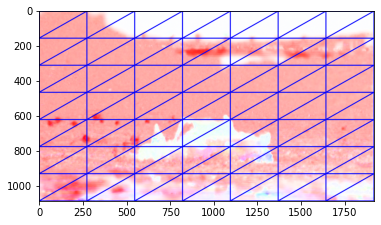

In [26]:
plt.imshow(flow_sub)
plt.show()

Iteration #100
Iteration #200
Iteration #300
Iteration #400


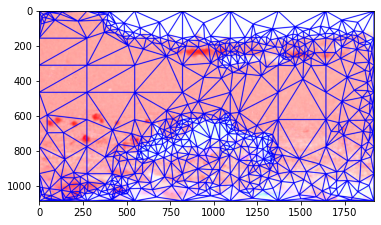

In [27]:
for i in range(1, 500):
    if i % 100 == 0:
        print("Iteration #" + str(i))
        
    best_triangle = choose_triangle(subdiv, corners, mv)
    best_point = find_point(subdiv, best_triangle)
    subdiv, corners = add_point(subdiv, corners, best_point)
    flow_sub = draw_delaunay(flow_img, subdiv, (0, 0, 255))
    images.append(flow_sub)
    # imageio.imsave(
    #     "iterative-subsampling/" + str(i) + ".png", 
    #     im=flow_copy_added, 
    #     format="png"
    # )

plt.imshow(flow_sub)
plt.show()

In [40]:
imageio.mimsave('adaptive-motion-subsampling-boat.gif', images[::5], fps=10)